In [19]:
import torch
import os

# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
!nvidia-smi

Wed Jun  5 09:43:38 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [27]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
import torchvision
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision import transforms as T
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split, Dataset
import copy
import math
from PIL import Image
import cv2
import albumentations as A  # our data augmentation library

import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
# remove arnings (optional)
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm # progress bar
from torchvision.utils import draw_bounding_boxes

In [13]:
#!pip install pycocotools
from pycocotools.coco import COCO

In [14]:
# Now, we will define our transforms
from albumentations.pytorch import ToTensorV2

In [28]:
def get_transforms(train=False):
    if train:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            A.HorizontalFlip(p=0.1),
            A.VerticalFlip(p=0.1),
            A.RandomBrightnessContrast(p=0.1),
            A.ColorJitter(p=0.1),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    else:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    return transform

In [29]:
class PedestrianDetection(datasets.VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None, transforms=None):
        # the 3 transform parameters are reuqired for datasets.VisionDataset
        super().__init__(root, transforms, transform, target_transform)
        self.split = split #train, valid, test
        self.coco = COCO(os.path.join(root, split, "_annotations.coco.json")) # annotatiosn stored here
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]

    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]['file_name']
        image = cv2.imread(os.path.join(self.root, self.split, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image
    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))

    def __getitem__(self, index):
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)
        target = copy.deepcopy(self._load_target(id))

        boxes = [t['bbox'] + [t['category_id']] for t in target] # required annotation format for albumentations
        if self.transforms is not None:
            transformed = self.transforms(image=image, bboxes=boxes)

        image = transformed['image']
        boxes = transformed['bboxes']

        new_boxes = [] # convert from xywh to xyxy
        for box in boxes:
            xmin = box[0]
            xmax = xmin + box[2]
            ymin = box[1]
            ymax = ymin + box[3]
            new_boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.tensor(new_boxes, dtype=torch.float32)

        targ = {} # here is our transformed target
        targ['boxes'] = boxes
        targ['labels'] = torch.tensor([t['category_id'] for t in target], dtype=torch.int64)
        targ['image_id'] = torch.tensor([t['image_id'] for t in target])
        targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) # we have a different area
        targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)
        return image.div(255), targ # scale images
    def __len__(self):
        return len(self.ids)

In [30]:
dataset_path = "/content/drive/MyDrive/pedestrian dataset(coco)/"

In [31]:
#load classes
coco = COCO(os.path.join(dataset_path, "train", "_annotations.coco.json"))
categories = coco.cats
n_classes = len(categories.keys())
categories

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


{0: {'id': 0, 'name': 'pedestrain', 'supercategory': 'none'},
 1: {'id': 1, 'name': 'nonhuman', 'supercategory': 'pedestrain'},
 2: {'id': 2, 'name': 'person', 'supercategory': 'pedestrain'}}

In [32]:
classes = [i[1]['name'] for i in categories.items()]
classes

['pedestrain', 'nonhuman', 'person']

In [33]:
train_dataset = PedestrianDetection(root=dataset_path, transforms=get_transforms(True))

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


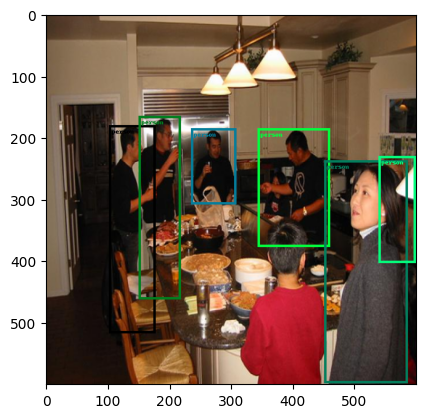

In [34]:
# Lets view a sample
sample = train_dataset[4]
img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)
plt.imshow(draw_bounding_boxes(
    img_int, sample[1]['boxes'], [classes[i] for i in sample[1]['labels']], width=4
).permute(1, 2, 0))

In [35]:
len(train_dataset)

916

In [36]:
# lets load the faster rcnn model
model = models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features # we need to change the head
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth
100%|██████████| 74.2M/74.2M [00:00<00:00, 185MB/s]


In [37]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [38]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=collate_fn)

In [39]:
images,targets = next(iter(train_loader))
images = list(image for image in images)
targets = [{k:v for k, v in t.items()} for t in targets]
output = model(images, targets) # just make sure this runs without err

In [40]:
device = torch.device("cuda")

In [41]:
model = model.to(device)

In [42]:
# Now, and optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, nesterov=True, weight_decay=1e-4)
# lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[16, 22], gamma=0.1) # lr scheduler

In [43]:
import sys
def train_one_epoch(model, optimizer, loader, device, epoch):
    model.to(device)
    model.train()

#     lr_scheduler = None
#     if epoch == 0:
#         warmup_factor = 1.0 / 1000 # do lr warmup
#         warmup_iters = min(1000, len(loader) - 1)

#         lr_scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor = warmup_factor, total_iters=warmup_iters)

    all_losses = []
    all_losses_dict = []

    for images, targets in tqdm(loader):
        images = list(image.to(device) for image in images)
        targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets) # the model computes the loss automatically if we pass in targets
        losses = sum(loss for loss in loss_dict.values())
        loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
        loss_value = losses.item()

        all_losses.append(loss_value)
        all_losses_dict.append(loss_dict_append)

        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping trainig") # train if loss becomes infinity
            print(loss_dict)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

#         if lr_scheduler is not None:
#             lr_scheduler.step() #

    all_losses_dict = pd.DataFrame(all_losses_dict) # for printing
    print("Epoch {}, lr: {:.6f}, loss: {:.6f}, loss_classifier: {:.6f}, loss_box: {:.6f}, loss_rpn_box: {:.6f}, loss_object: {:.6f}".format(
        epoch, optimizer.param_groups[0]['lr'], np.mean(all_losses),
        all_losses_dict['loss_classifier'].mean(),
        all_losses_dict['loss_box_reg'].mean(),
        all_losses_dict['loss_rpn_box_reg'].mean(),
        all_losses_dict['loss_objectness'].mean()
    ))

In [44]:
num_epochs=10

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch)
#     lr_scheduler.step()

100%|██████████| 229/229 [02:52<00:00,  1.33it/s]


Epoch 0, lr: 0.010000, loss: 0.623987, loss_classifier: 0.244946, loss_box: 0.296468, loss_rpn_box: 0.040428, loss_object: 0.042145


100%|██████████| 229/229 [00:38<00:00,  5.88it/s]


Epoch 1, lr: 0.010000, loss: 0.575974, loss_classifier: 0.226788, loss_box: 0.292116, loss_rpn_box: 0.032787, loss_object: 0.024282


100%|██████████| 229/229 [00:39<00:00,  5.86it/s]


Epoch 2, lr: 0.010000, loss: 0.550983, loss_classifier: 0.217772, loss_box: 0.280544, loss_rpn_box: 0.030769, loss_object: 0.021896


100%|██████████| 229/229 [00:38<00:00,  5.97it/s]


Epoch 3, lr: 0.010000, loss: 0.570174, loss_classifier: 0.228633, loss_box: 0.294053, loss_rpn_box: 0.029927, loss_object: 0.017561


100%|██████████| 229/229 [00:37<00:00,  6.03it/s]


Epoch 4, lr: 0.010000, loss: 0.526052, loss_classifier: 0.202244, loss_box: 0.280577, loss_rpn_box: 0.026804, loss_object: 0.016427


100%|██████████| 229/229 [00:38<00:00,  6.01it/s]


Epoch 5, lr: 0.010000, loss: 0.536403, loss_classifier: 0.203555, loss_box: 0.288054, loss_rpn_box: 0.027961, loss_object: 0.016834


100%|██████████| 229/229 [00:38<00:00,  6.01it/s]


Epoch 6, lr: 0.010000, loss: 0.491939, loss_classifier: 0.179838, loss_box: 0.271305, loss_rpn_box: 0.026313, loss_object: 0.014483


100%|██████████| 229/229 [00:38<00:00,  5.95it/s]


Epoch 7, lr: 0.010000, loss: 0.512819, loss_classifier: 0.189451, loss_box: 0.285894, loss_rpn_box: 0.025105, loss_object: 0.012368


100%|██████████| 229/229 [00:37<00:00,  6.03it/s]


Epoch 8, lr: 0.010000, loss: 0.496121, loss_classifier: 0.181709, loss_box: 0.279217, loss_rpn_box: 0.023455, loss_object: 0.011741


100%|██████████| 229/229 [00:36<00:00,  6.22it/s]

Epoch 9, lr: 0.010000, loss: 0.495105, loss_classifier: 0.182713, loss_box: 0.279330, loss_rpn_box: 0.022796, loss_object: 0.010266


In [45]:
model.eval()
torch.cuda.empty_cache()

In [47]:
test_dataset = PedestrianDetection(root=dataset_path, split="test", transforms=get_transforms(False))

loading annotations into memory...
Done (t=0.62s)
creating index...
index created!


In [71]:
img, _ = test_dataset[198]
img_int = torch.tensor(img*255, dtype=torch.uint8)
with torch.no_grad():
    prediction = model([img.to(device)])
    pred = prediction[0]

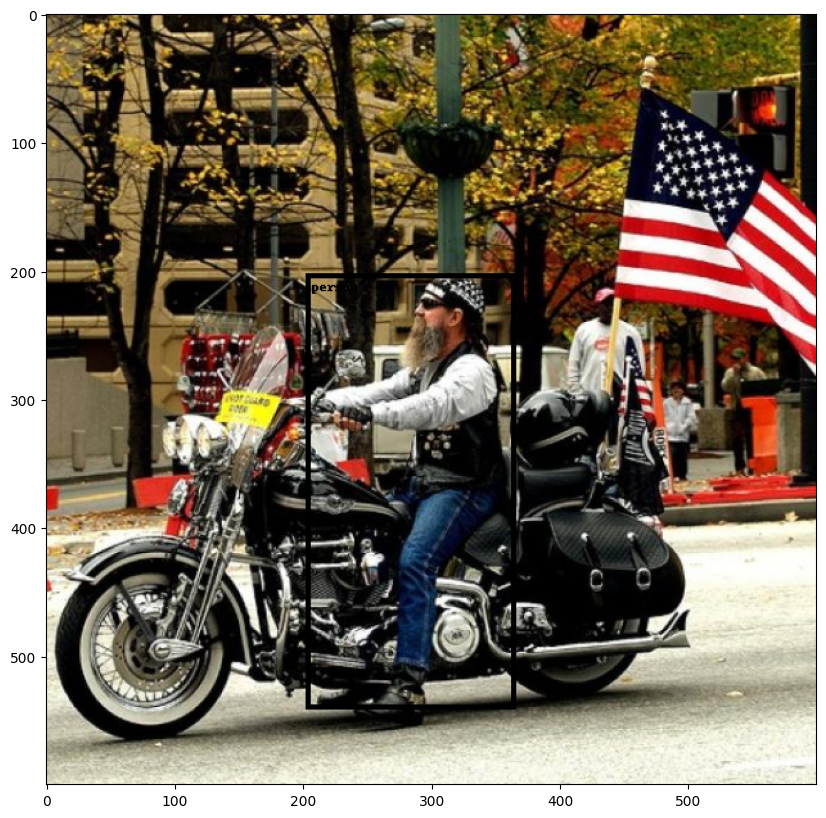

In [72]:
fig = plt.figure(figsize=(14, 10))
plt.imshow(draw_bounding_boxes(img_int,
    pred['boxes'][pred['scores'] > 0.8],
    [classes[i] for i in pred['labels'][pred['scores'] > 0.8].tolist()], width=4
).permute(1, 2, 0))

In [50]:
torch.save(model, 'fine_tuned_faster_rcnn.pth')

In [82]:
import os
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes



# Path to the folder in Google Drive where you want to save the images
save_folder = "/content/drive/MyDrive/pedestrian dataset(coco)/results"

# Create the save folder if it doesn't exist
os.makedirs(save_folder, exist_ok=True)

# Iterate through the test dataset
for i in range(len(test_dataset)):
    img, _ = test_dataset[i]
    img_int = torch.tensor(img*255, dtype=torch.uint8)  # Convert image to uint8 and change shape to (height, width, channels)
    with torch.no_grad():
        prediction = model([img.to(device)])

    # Filter predictions with confidence score greater than 0.8
    pred_boxes = prediction[0]['boxes'][prediction[0]['scores'] > 0.8]
    pred_labels = [classes[i] for i in prediction[0]['labels'][prediction[0]['scores'] > 0.8].tolist()]

    # Draw bounding boxes on the image
    img_with_boxes = draw_bounding_boxes(img_int, pred_boxes, pred_labels,width=5, colors="red" )  # Unsqueeze to match batch dimension

    # Plot and save the image with bounding boxes to the specified folder in Google Drive
    plt.imshow(img_with_boxes.permute(1, 2, 0))  # Ensure image data has the correct shape and format
    plt.axis('off')
    plt.savefig(os.path.join(save_folder, f'prediction_{i}.png'))
    plt.close()
